In [1]:
import xarray
import xarray as xr
from datetime import datetime, timedelta
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.pyplot import cm
import matplotlib.lines as mlines
import cartopy.crs as ccrs
import numpy as np
from plot_common import annotate_skill, autoextend_colorbar, corners, get_map_norm
import xesmf
import subprocess
from typing import Any, Callable, Union
import cartopy.feature as cfeature
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
from shapely.geometry import MultiPoint
import regionmask
import cftime
import xskillscore as xs
from sklearn.utils import resample
from multiprocessing import Pool
import useful_functions
import importlib
importlib.reload(useful_functions)

from useful_functions import get_nwa12_outfile, weighted_annual_mean, \
                             area_masked_weighted_average, plot_epu, load_ecodata, \
                             plot_coldpool, compute_gs_points, compute_gs_expts, plot_gs, \
                             plot_epu_dclim, plot_epu_chlos_dclim, plot_epu_mclim, compute_epu_daily_clim

import warnings
warnings.filterwarnings('ignore', 'Converting a CFTimeIndex')
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
VARNAME = 'tob'
clim_start = 1965
clim_end = 2019

In [4]:
%%time

if VARNAME=='tob':

    ds_roms_neus = xarray.open_dataset('/work/vnk/obs_and_reanalyses/bot_tmp_obs_epu_mwfc/daily_bottom_temp_neus_1959_2019.nc')
    
    ds_roms_neus = ds_roms_neus.stack(time=('year', 'day'))
    
    ds_roms_neus = ds_roms_neus.reset_index('time')
    
    year = ds_roms_neus['year'].astype(int)
    day = ds_roms_neus['day'].astype(int)
    time = np.array([np.datetime64(f'{y}-01-01') + np.timedelta64(d - 1, 'D') for y, d in zip(year.values.flat, day.values.flat)])
    time = time.astype('datetime64[ns]')
    ds_roms_neus = ds_roms_neus.assign_coords(time=time) \
                        .drop_vars(['year', 'day']).rename({'bt_temp': 'tob'}) \
                        .sel(time=slice('1965-01-01', '2019-12-31'))
    
    roms_ym = weighted_annual_mean(ds_roms_neus)
    roms_ym = roms_ym - roms_ym.sel(time=slice(f'{clim_start}-01-01',f'{clim_end}-12-31')).mean(dim='time')
    roms_ym

CPU times: user 12.7 s, sys: 4.09 s, total: 16.8 s
Wall time: 12.7 s


In [5]:
%%time

if VARNAME=='tos':

    ds_glorys = xarray.open_dataset('/work/acr/mom6/diagnostics/glorys/glorys_sfc.nc').drop_vars('so')
    
    glorys_ym = weighted_temporal_mean(ds_glorys).rename({'thetao': 'tos'}) \
                        .sel(time=slice('1993-01-01', '2022-12-31'))
    
    glorys_ym = glorys_ym - glorys_ym.mean(dim='time')
    glorys_ym

CPU times: user 3 μs, sys: 1 μs, total: 4 μs
Wall time: 7.39 μs


In [6]:
%%time

if VARNAME=='tob':

    # Open the netCDF file
    ds_glorys = xarray.open_mfdataset(
        '/work/acr/glorys/GLOBAL_MULTIYEAR_PHY_001_030/monthly/glorys_monthly_ts_fine_????.nc', 
        combine='by_coords') \
        .rename({'latitude': 'lat', 'longitude': 'lon'})['thetao'].ffill(dim='depth').isel(depth=-1)
    
    glorys = ds_glorys.sel(time=slice('1993-01-01', '2019-12-31')) \
                      .sel(lon=slice(280-360, 320-360), lat=slice(30, 52)) \
                      .drop_vars('depth').to_dataset(name='tob')
    
    glorys_ym = weighted_annual_mean(glorys).load()
    glorys_ym = glorys_ym - glorys_ym.sel(time=slice(f'{clim_start}-01-01',f'{clim_end}-12-31')).mean(dim='time')
    glorys_ym

CPU times: user 2min 54s, sys: 1min 40s, total: 4min 34s
Wall time: 5min 43s


In [7]:
%%time

if VARNAME=='tos':

    ds_oisst = xarray.open_dataset('/work/vnk/obs_and_reanalyses/oisst_v2/sst.mon.mean.nc')
    
    oisst_ym = weighted_temporal_mean(ds_oisst).sel(time=slice('1982-01-01', '2022-12-31')) \
                        .rename({'sst': 'tos'}) 
    oisst_ym = oisst_ym - oisst_ym.sel(time=slice(f'{clim_start}-01-01',f'{clim_end}-12-31')).mean(dim='time')
    oisst_ym

CPU times: user 18 μs, sys: 10 μs, total: 28 μs
Wall time: 57.7 μs


In [8]:
%%time

if VARNAME=='tos':

    # Open the netCDF file
    ds_ersst = xarray.open_dataset('/work/vnk/obs_and_reanalyses/ersst_v5/sst.mnmean.nc')
    
    ersst_ym = weighted_temporal_mean(ds_ersst.drop_vars('time_bnds')).rename({'sst': 'tos'}) \
                        .sel(time=slice('1965-01-01', '2022-12-31'))
    
    ersst_ym = ersst_ym - ersst_ym.sel(time=slice(f'{clim_start}-01-01',f'{clim_end}-12-31')).mean(dim='time')
    ersst_ym

CPU times: user 31 μs, sys: 0 ns, total: 31 μs
Wall time: 58.9 μs


In [12]:
#epu_shp_file = '/home/acr/git/nwa-shared/NWA12/data/geography/EPU_NOESTUARIES/EPU_NOESTUARIES.shp'
#lmes_shp_file = '/home/acr/git/nwa-shared/NWA12/data/geography/lmes/lme66.shp'

epu_shp_file = '/home/vnk/scripts/analysis/scripts_post_202412/BSB_shape/bsb_shape.shp'


In [26]:
def weighted_average(data, area):
    averaged_data = data.weighted(area).mean(['lat', 'lon'])
    return averaged_data

def area_masked_weighted_average(epu_shp_file, grid_area, in_file):
    # Load the mask data
    epu_shp = gpd.read_file(epu_shp_file)

    # Set the number of regions
    nregions = 2
    
    # Create a region mask for the EPU data
    epu_mask_poly = regionmask.Regions(
        name='Region',
        numbers=list(range(0, nregions)),
        names=list(epu_shp.Region),
        abbrevs=list(epu_shp.Region),
        outlines=[epu_shp.geometry.values[i] for i in range(0, nregions)]
    )
    
    # Create a mask for the EPU and LMES data using the observation dataset
    if 'time' in in_file.dims:
        mask_epu = epu_mask_poly.mask(in_file.isel(time=0), lat_name='lat', lon_name='lon')
    else:
        mask_epu = epu_mask_poly.mask(in_file, lat_name='lat', lon_name='lon')
    
    # Set the EPU regions to process
    epu = ['BAS']
    
    # Initialize lists to store results
    in_file_list = []
              
    area = grid_area.where(mask_epu==0).fillna(0)    
        
    area.name = "weights"
    in_file_epu = weighted_average(in_file, area)
    
    return in_file_epu, mask_epu 

In [27]:
%%time

if VARNAME=='tob':

    ds_roms_neus_grid = xarray.open_dataset('/work/vnk/obs_and_reanalyses/bot_tmp_obs_epu_mwfc/daily_bottom_temp_neus_1959_2019_grid.nc')
    
    roms_epu, mask_epu_roms = area_masked_weighted_average(
                            epu_shp_file, 
                            ds_roms_neus_grid.cell_area, 
                            roms_ym.copy())
    roms_epu

CPU times: user 31.6 ms, sys: 0 ns, total: 31.6 ms
Wall time: 32.2 ms


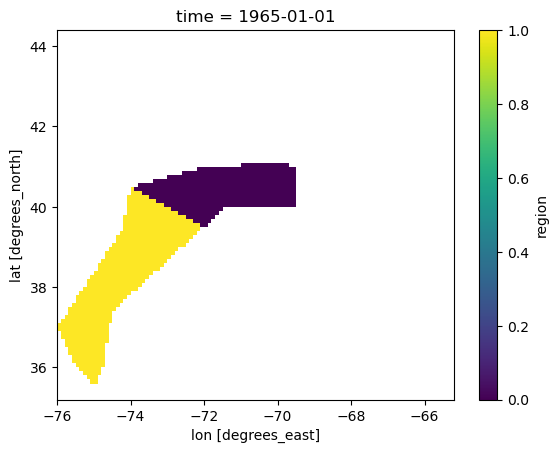

In [31]:
mask_epu_roms.plot()

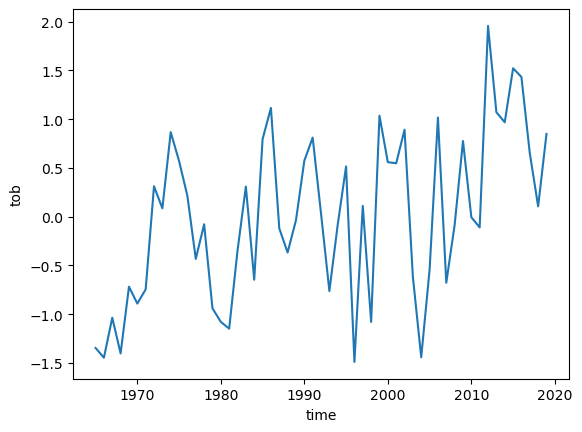

In [30]:
roms_epu.tob.plot()

In [27]:
%%time

glorys_grid = xarray.open_dataset('/work/vnk/obs_and_reanalyses/glorys12/GLO-MFC_001_030_areacello.nc').areacello
glorys_grid = glorys_grid.rename({'latitude': 'lat', 'longitude': 'lon'})

glorys_epu, mask_epu_glorys, mask_lmes_glorys  = area_masked_weighted_average(
                        epu_shp_file, 
                        lmes_shp_file, 
                        glorys_grid, 
                        glorys_ym.copy())
glorys_epu

CPU times: user 741 ms, sys: 81.5 ms, total: 822 ms
Wall time: 1.49 s


<xarray.Dataset> Size: 2kB
Dimensions:  (epu: 6, time: 27)
Coordinates:
  * time     (time) datetime64[ns] 216B 1993-01-01 1994-01-01 ... 2019-01-01
Dimensions without coordinates: epu
Data variables:
    tob      (epu, time) float64 1kB -1.155 -0.4161 0.2402 ... 0.7413 0.4912

In [ ]:
%%time

if VARNAME=='tos':

    oisst_grid = xarray.open_dataset('/work/vnk/obs_and_reanalyses/oisst_v2/sst.mon.mean.grid.nc')
    
    oisst_epu, mask_epu_oisst, mask_lmes_oisst = area_masked_weighted_average(
                            epu_shp_file, 
                            lmes_shp_file, 
                            oisst_grid.cell_area, 
                            oisst_ym.copy())
    oisst_epu

In [ ]:
%%time

if VARNAME=='tos':

    ersst_grid = xarray.open_dataset('/work/vnk/obs_and_reanalyses/ersst_v5/sst.mnmean.grid.nc')
    
    ersst_epu, mask_epu_ersst, mask_lmes_ersst = area_masked_weighted_average(
                            epu_shp_file, 
                            lmes_shp_file, 
                            ersst_grid.cell_area, 
                            ersst_ym.copy())
    ersst_epu

In [28]:
if VARNAME=='tob' or VARNAME=='tos':

    long_names_ordered = {
        'SS': 'Scotian Shelf',
        'GOM': 'Gulf of Maine',
        'GB': 'Georges Bank',
        'MAB': 'Mid-Atlantic Bight'
    }
    
    obs_list = []
    obs_ref_list = []

    if VARNAME=='tob':
        obs_varname='Tbot'
    elif VARNAME=='tos':
        obs_varname='Tsfc'            

    for epu in long_names_ordered:
        obs, obs_ref = load_ecodata(epu, obs_varname)
        obs_da = xr.DataArray.from_series(obs)
        obs_ref_da = xr.DataArray.from_series(obs_ref)
    
        obs_list.append(obs_da)
        obs_ref_list.append(obs_ref_da)
    
    obs_da = xr.concat(obs_list, dim=pd.Index(long_names_ordered, name='epu')).resample(time='YS').mean()
    obs_ref_da = xr.concat(obs_ref_list, dim=pd.Index(long_names_ordered, name='epu')).resample(time='YS').mean()
    
    ds_obs_epu = []
    ds_obs_ref_epu = []
    
    for epu in ['MAB', 'GOM', 'SS', 'GB']:
    
        obs_epu_ds = obs_da.sel(epu=epu).drop_vars('epu')
        ds_obs_epu.append(obs_epu_ds)
        
        obs_ref_epu_ds = obs_ref_da.sel(epu=epu).drop_vars('epu')
        ds_obs_ref_epu.append(obs_ref_epu_ds)
        
    obs_epu = xr.concat(ds_obs_epu, dim='epu').to_dataset().rename({f'{obs_varname}_anom':f'{VARNAME}'})
    obs_ref_epu = xr.concat(ds_obs_ref_epu, dim='epu').to_dataset().rename({f'{obs_varname}_ref':f'{VARNAME}'})
    obs_epu['epu'] = np.arange(4)
    obs_ref_epu['epu'] = np.arange(4)
    obs_epu

<xarray.Dataset> Size: 2kB
Dimensions:  (time: 45, epu: 4)
Coordinates:
  * time     (time) datetime64[ns] 360B 1977-01-01 1978-01-01 ... 2021-01-01
  * epu      (epu) int64 32B 0 1 2 3
Data variables:
    tob      (epu, time) float64 1kB -0.8558 -1.302 -1.17 ... 0.54 nan 1.258

In [35]:
%%time

roms_epu_file_path = f'/work/vnk/outdata_for_analysis/roms_epu_annual_{VARNAME}.nc'
glorys_epu_file_path = f'/work/vnk/outdata_for_analysis/glorys_epu_annual_{VARNAME}.nc'
obs_epu_file_path = f'/work/vnk/outdata_for_analysis/obs_epu_annual_{VARNAME}.nc'

if not os.path.exists(roms_epu_file_path):
    roms_epu.to_netcdf(path=roms_epu_file_path, invalid_netcdf=False)
else:
    os.remove(roms_epu_file_path)
    roms_epu.to_netcdf(path=roms_epu_file_path, invalid_netcdf=False)

    
if not os.path.exists(obs_epu_file_path):
    obs_epu.to_netcdf(path=obs_epu_file_path, invalid_netcdf=False)
else:
    os.remove(obs_epu_file_path)
    obs_epu.to_netcdf(path=obs_epu_file_path, invalid_netcdf=False)
    
    
if not os.path.exists(glorys_epu_file_path):
    glorys_epu.to_netcdf(path=glorys_epu_file_path, invalid_netcdf=False)
else:
    os.remove(glorys_epu_file_path)
    glorys_epu.to_netcdf(path=glorys_epu_file_path, invalid_netcdf=False)

CPU times: user 41.1 ms, sys: 8.24 ms, total: 49.4 ms
Wall time: 84.2 ms
